In [6]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
import deepxde.deepxde.backend as bkd
from datasets import makeTesting
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet

In [7]:
if False:
    makeTesting()

In [8]:
def pde(x, y):
    vx = x[0].repeat_interleave(101)[:,None]

    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    return dy_t - D * dy_xx + k * y**2 - vx

In [9]:
space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="cubic")
vxs = space.eval_batch(space.random(20), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = 6)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load("datasets/DF_100_0.1_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


Compiling model...
'compile' took 0.001012 s

Training model...

0         [1.31e-01]    [3.75e-01]    [1.47e+00]    
1000      [4.34e-02]    [7.36e-02]    [6.80e-01]    
2000      [1.38e-02]    [7.38e-02]    [6.82e-01]    
3000      [1.13e-02]    [7.32e-02]    [6.82e-01]    
4000      [2.52e-02]    [6.57e-02]    [6.43e-01]    
5000      [2.24e-02]    [5.61e-02]    [5.93e-01]    
6000      [1.64e-02]    [5.84e-02]    [5.94e-01]    
7000      [3.87e-02]    [5.88e-02]    [6.00e-01]    
8000      [9.45e-03]    [5.73e-02]    [5.94e-01]    
9000      [5.08e-03]    [5.61e-02]    [5.81e-01]    
10000     [2.69e-03]    [5.55e-02]    [5.71e-01]    
11000     [4.11e-03]    [5.26e-02]    [5.59e-01]    
12000     [2.76e-03]    [5.32e-02]    [5.61e-01]    
13000     [2.33e-03]    [5.22e-02]    [5.55e-01]    
14000     [2.61e-03]    [5.27e-02]    [5.59e-01]    
15000     [2.45e-03]    [5.08e-02]    [5.54e-01]    
16000     [2.94e-03]    [5.01e-02]    [5.50e-01]    
17000     [2.91e-03]    [5.05e-02]

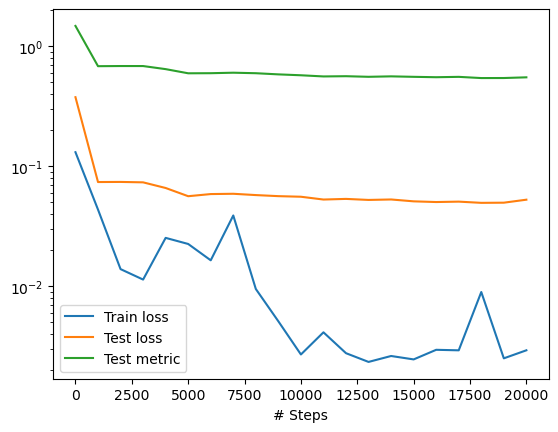

In [10]:
data = dde.data.TripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts)

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 128, 128, 128],
    [2, 128, 128, 128],
    bkd.gelu,
    "Glorot normal",
)

net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam", lr=1E-3, metrics = ["mean l2 relative error"], decay = ("lambda", lambda step: 1 / (1 + 0.5 * (step / (5000 // 5)))))
losshistory, train_state = model.train(iterations=20000, batch_size = 1)
dde.utils.plot_loss_history(losshistory)

In [12]:

while len(train_vxs) < 1000:
    # generate some vxs to test
    x_space = np.linspace(0, 1, 101)
    t_space = np.linspace(0, 1, 101)
    vxs = space.eval_batch(space.random(1000), x_space[:, None]) # generate 1000 random vxs
    grid = np.asarray(np.meshgrid(x_space, t_space, indexing = "ij")).transpose([1,2,0]).reshape(101 * 101, -1)
    res = model.predict((vxs, grid), operator = pde)
    res = np.mean(np.abs(res[...,0]), axis = 1)
    print(np.mean(res), np.std(res))
    topk_index = np.argpartition(res, -20)[-20:] # select the top 20 vxs
    topk_vxs = vxs[topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = 6)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = dde.data.TripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts)
    
    model = dde.Model(data, net)
    batchsize = len(train_vxs) // 10
    lr = 1E-3 * np.exp(-len(train_vxs) / 200)
    model.compile("adam", 
                  lr=1e-3, 
                  metrics = ["mean l2 relative error"], 
                  decay = ("lambda", lambda step: 1 / (1 + 0.5 * (step / (20000 // 5)))))
    losshistory, train_state = model.train(iterations=20000, batch_size = batchsize)
        


0.05369689 0.19706166
200
Compiling model...
'compile' took 0.000373 s

Training model...

0         [5.02e-05]    [1.11e-03]    [8.38e-02]    
1000      [1.34e-04]    [1.00e-03]    [7.82e-02]    
2000      [7.81e-05]    [9.84e-04]    [7.72e-02]    
3000      [8.40e-05]    [9.89e-04]    [7.81e-02]    
4000      [1.24e-04]    [9.44e-04]    [7.62e-02]    
5000      [9.17e-05]    [9.54e-04]    [7.49e-02]    
6000      [2.98e-05]    [8.59e-04]    [7.21e-02]    
7000      [8.90e-05]    [1.01e-03]    [7.71e-02]    
8000      [5.03e-05]    [8.94e-04]    [7.23e-02]    
9000      [2.14e-05]    [8.40e-04]    [7.08e-02]    
10000     [2.82e-05]    [8.26e-04]    [7.03e-02]    
11000     [4.53e-05]    [8.36e-04]    [7.06e-02]    
12000     [3.05e-05]    [8.40e-04]    [7.07e-02]    
13000     [2.03e-05]    [8.18e-04]    [6.97e-02]    
14000     [1.31e-05]    [8.12e-04]    [6.94e-02]    
15000     [1.37e-05]    [8.07e-04]    [6.93e-02]    
16000     [1.83e-05]    [7.94e-04]    [6.91e-02]    
17000   

KeyboardInterrupt: 